# Navigation

---
### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
env = UnityEnvironment(file_name="Banana_Windows_x86_64/Banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 2.0


When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

# -------------------------------------------------------------------------------------------------------------

# Deep Neural Network

In [28]:
import random
import numpy as np
import pandas as pd
from collections import namedtuple, deque
import seaborn as sns
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(15,7)})

import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gym

device = T.device("cuda:0" if T.cuda.is_available() else "cpu")

In [29]:
class DeepNeuralNetwork(nn.Module):
    def __init__(self, state_shape, action_shape, layers=[64, 128], lr=0.0005):
        super(DeepNeuralNetwork, self).__init__()          
        self.state_shape = state_shape
        self.action_shape = action_shape
        self.layers = layers
        self.lr = lr

        #Allows to create layers dynamically
        self.fc = nn.ModuleList()

        self.fc.append(nn.Linear(state_shape, layers[0]))

        for i in range(len(self.layers)-1):
            self.fc.append(nn.Linear(layers[i], layers[i+1]))
                
        self.v = nn.Linear(self.layers[-1], 1)
        self.a = nn.Linear(self.layers[-1], self.action_shape)

        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        self.to(device)
            
    def forward(self, state):
        x = F.relu(self.fc[0](state))

        for i in range(len(self.layers)-1):
            x = F.relu(self.fc[i+1](x))
        
        v = self.v(x)
        a = self.a(x)

        output = v + (a - a.mean(1).unsqueeze(1))

        return output

# Replay Buffer

In [30]:
class ReplayBuffer:
    def __init__(self, buffer_size, batch_size):
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
    
    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = T.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = T.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = T.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = T.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = T.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

# Agent

In [34]:
BUFFER_SIZE = int(100000)  # replay buffer size
BATCH_SIZE = 64            # minibatch size
GAMMA = 0.99               # discount factor
TAU = 0.001                # for soft update of target parameters
LR = 0.0005                # learning rate 
UPDATE_EVERY = 4           # how often to update the network
LAYERS = [64, 128]         # neural network num of layers

class Agent():

    def __init__(self, state_shape, action_shape):
        self.state_shape = state_shape
        self.action_shape = action_shape
                
        # Neural nets    
        self.dqn_local  = DeepNeuralNetwork(self.state_shape, self.action_shape, layers=LAYERS, lr=LR)
        self.dqn_target = DeepNeuralNetwork(self.state_shape, self.action_shape, layers=LAYERS, lr=LR)
            
        # Replay memory
        self.memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE)
        self.update_control = 0
    
    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)
        
        self.update_control += 1
        if self.update_control == UPDATE_EVERY:

            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)
            
            self.update_control = 0
            

    def act(self, state, eps=0.):
        state = T.from_numpy(state).float().unsqueeze(0).to(device)
        self.dqn_local.eval()
        with T.no_grad():
            action_values = self.dqn_local(state)
        self.dqn_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy()).astype(np.int32)
        else:
            return random.choice(np.arange(self.action_shape))        
        

    def learn(self, experiences, gamma):

        states, actions, rewards, next_states, dones = experiences

        # 1) Obtain values for next states from local net
        q_local_next_states = self.dqn_local.forward(next_states)
        
        # 2) Obtain actions for next states from local net
        _, q_local_next_states_action = T.max(q_local_next_states, dim=1)
        
        # 3) Obtain values for next states from target net
        q_target_next_states = self.dqn_target.forward(next_states)
        
        # 4) Use actions from local net to obtain next state Q values from target net
        q_target_next_states_action = q_target_next_states[T.arange(BATCH_SIZE, dtype=T.long), q_local_next_states_action.reshape(BATCH_SIZE)]

        # 5) Calculate Y for target
        q_target_next_states_action = q_target_next_states_action * (1 - dones.reshape(BATCH_SIZE)) 
        q_target_next_states_action = q_target_next_states_action.reshape((BATCH_SIZE,1))
        Y_t = rewards + gamma * q_target_next_states_action
        
        # 6) Calculate Y for local
        q_local_states = self.dqn_local.forward(states)
        Y_l = q_local_states[T.arange(BATCH_SIZE, dtype=T.long), actions.reshape(BATCH_SIZE)]
        Y_l = Y_l.reshape((BATCH_SIZE,1))
        
        # 7) Process backpropagation
        loss = F.mse_loss(Y_l, Y_t)

        self.dqn_local.optimizer.zero_grad()
        loss.backward()
        self.dqn_local.optimizer.step()

        # 8) Update target network parameters
        self.update(self.dqn_local, self.dqn_target, TAU)                     

    def update(self, local_model, target_model, tau):

        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
            
    def save_model(self):
        T.save(self.dqn_local.state_dict(), 'trained_model.pth')
        
    def load_model(self):
        self.dqn_local.load_state_dict(T.load('trained_model.pth'))
        self.dqn_local.eval()

# Train

In [35]:
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 0.995
N_GAMES = 2000
scores= []
average = []

agent = Agent(state_shape=37, action_shape=4)

eps = EPS_START

for episode in range(N_GAMES):
    
    env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
    state = env_info.vector_observations[0]            # get the current state
    
    score = 0
    done = False
    
    while not done:  
        action = agent.act(state)                      # select an action
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]                  # see if episode has finished
        score += reward                                # update the score

        agent.step(state, action, reward, next_state, done)

        state = next_state                             # roll over the state to next time step
    
    scores.append(score)
    avg_score = np.mean(scores[-100:])
    average.append(avg_score)
    
    eps = max(EPS_END, eps * EPS_DECAY)

    if episode % 100 == 0 and episode != 0:
        print('Game {0}  --->  Avg Reward: {1}'.format(episode, round(np.mean(avg_score), 2), end=""))
        agent.save_model()
    
average = pd.DataFrame(average, columns=['Reward'])

Game 100  --->  Avg Reward: 2.05
Game 200  --->  Avg Reward: 7.22
Game 300  --->  Avg Reward: 11.78
Game 400  --->  Avg Reward: 13.11
Game 500  --->  Avg Reward: 15.08
Game 600  --->  Avg Reward: 16.04
Game 700  --->  Avg Reward: 15.78
Game 800  --->  Avg Reward: 17.0
Game 900  --->  Avg Reward: 15.84
Game 1000  --->  Avg Reward: 15.73
Game 1100  --->  Avg Reward: 15.4
Game 1200  --->  Avg Reward: 16.53
Game 1300  --->  Avg Reward: 16.61
Game 1400  --->  Avg Reward: 15.81
Game 1500  --->  Avg Reward: 16.51
Game 1600  --->  Avg Reward: 16.12
Game 1700  --->  Avg Reward: 16.83
Game 1800  --->  Avg Reward: 16.42
Game 1900  --->  Avg Reward: 16.16


<AxesSubplot:ylabel='Reward'>

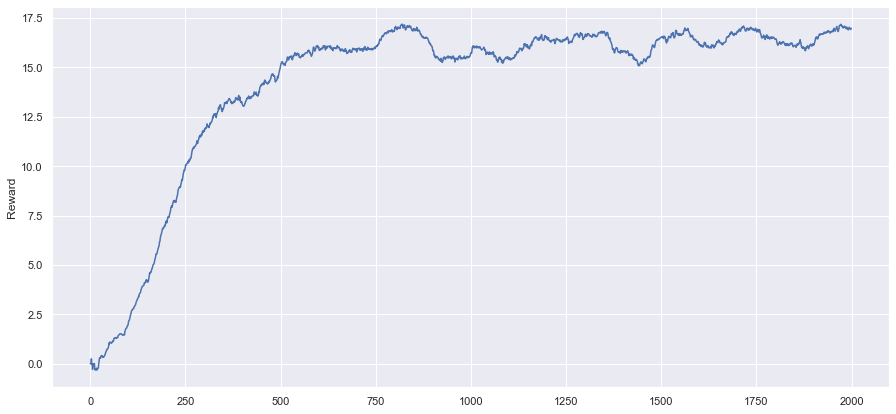

In [36]:
sns.lineplot(x=average.index, y=average.Reward, data=average)

# Testing the agent

In [37]:
agent = Agent(state_shape=37, action_shape=4)   # load trained model
agent.load_model()

env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = agent.act(state)                 # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 20.0
